In [158]:
# %cd ..

## Create Zarr file

In [159]:
import xarray as xr
import numpy as np
import zarr

# Load dataset
ds = xr.open_dataset("data/SST.nc", chunks={'lat': 224, 'lon': 224})

# Extract dimensions
latitudes = ds.lat.values
longitudes = ds.lon.values
time = ds.time.values
tile_size = 224

# Create Zarr store
store = zarr.open("tiles_output.zarr", mode="w")

# Compute number of tiles
n_tiles_lat = (len(latitudes) + tile_size - 1) // tile_size
n_tiles_lon = (len(longitudes) + tile_size - 1) // tile_size

# Calculate total number of tiles
total_tiles = len(time) * n_tiles_lat * n_tiles_lon

# Create storage arrays with new shape (total_tiles, tile_size, tile_size)
sst_array = store.create('analysed_sst', 
                         shape=(total_tiles, tile_size, tile_size),
                         dtype='float32', 
                         chunks=(1, tile_size, tile_size))

# Create arrays to store metadata for each tile - FIX: Removed duplicate creation
tile_metadata = store.create('tile_metadata', 
                            shape=(total_tiles, 2),  # Store lat_idx, lon_idx
                            dtype='int32')

# Create separate arrays for latitude and longitude references
lat_array = store.create('latitudes', 
                         shape=(n_tiles_lat, tile_size),
                         dtype='float32')
lon_array = store.create('longitudes', 
                         shape=(n_tiles_lon, tile_size),
                         dtype='float32')

# Store the latitude and longitude references
for i in range(n_tiles_lat):
    start_idx = i * tile_size
    end_idx = min(start_idx + tile_size, len(latitudes))
    if end_idx - start_idx == tile_size:  # Only store complete tiles
        lat_array[i, :] = latitudes[start_idx:end_idx]

for i in range(n_tiles_lon):
    start_idx = i * tile_size
    end_idx = min(start_idx + tile_size, len(longitudes))
    if end_idx - start_idx == tile_size:  # Only store complete tiles
        lon_array[i, :] = longitudes[start_idx:end_idx]

# Iterate and store tiles
tile_idx = 0
for t_idx in range(len(time)):
    sst_t = ds.analysed_sst.isel(time=t_idx)
    
    for lat_idx in range(0, len(latitudes), tile_size):
        for lon_idx in range(0, len(longitudes), tile_size):
            # Extract tile ensuring 224x224 shape
            sst_tile = sst_t.isel(lat=slice(lat_idx, lat_idx + tile_size), 
                                  lon=slice(lon_idx, lon_idx + tile_size))
            
            # Skip tiles that are smaller than the desired size
            if sst_tile.shape != (tile_size, tile_size):
                continue
            
            # Store the tile
            sst_array[tile_idx] = sst_tile.values
            
            # Store metadata (lat_tile, lon_tile indices)
            tile_metadata[tile_idx] = [lat_idx // tile_size, lon_idx // tile_size]
            
            tile_idx += 1

# Update the actual number of tiles if some were skipped
if tile_idx < total_tiles:
    sst_array.resize(tile_idx, tile_size, tile_size)
    tile_metadata.resize(tile_idx, 2)

# Create a dataset attributes to store information about the original dimensions
store.attrs['time_values'] = [str(t) for t in time]
store.attrs['n_times'] = len(time)
store.attrs['n_tiles_lat'] = n_tiles_lat
store.attrs['n_tiles_lon'] = n_tiles_lon
store.attrs['tile_size'] = tile_size

print(f"All tiles saved successfully. Total tiles: {tile_idx}")

/tmp/ipykernel_659251/2169689970.py:6: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 224. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset("data/SST.nc", chunks={'lat': 224, 'lon': 224})
/tmp/ipykernel_659251/2169689970.py:6: UserWarning: The specified chunks separate the stored chunks along dimension "lon" starting at index 224. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset("data/SST.nc", chunks={'lat': 224, 'lon': 224})


All tiles saved successfully. Total tiles: 1536


## Check dataset info

In [160]:
import zarr

# Open the existing Zarr store
store = zarr.open("tiles_output.zarr", mode="r")
# Access a specific dataset
dataset_key = 'analysed_sst'
dataset = store[dataset_key]

# Print dataset information
print(f"\nInformation about the dataset '{dataset_key}':")
print(f"Shape: {dataset.shape}")
print(f"Data type: {dataset.dtype}")
print(f"Chunks: {dataset.chunks}")


Information about the dataset 'analysed_sst':
Shape: (1536, 224, 224)
Data type: float32
Chunks: (1, 224, 224)


## Plot some tiles

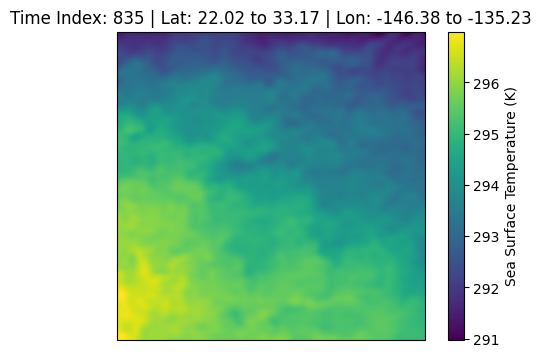

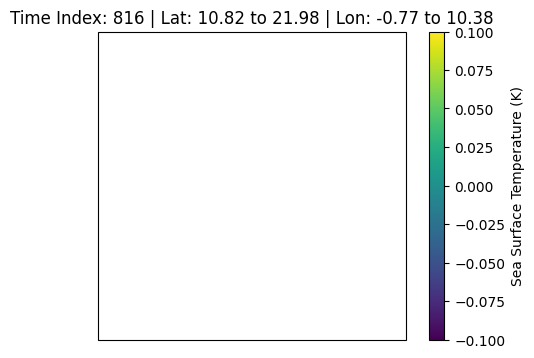

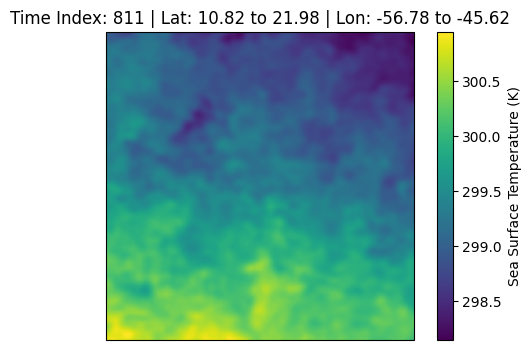

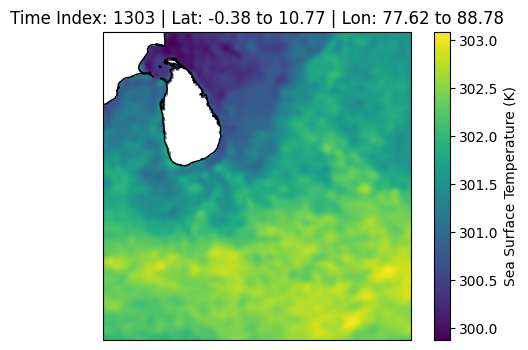

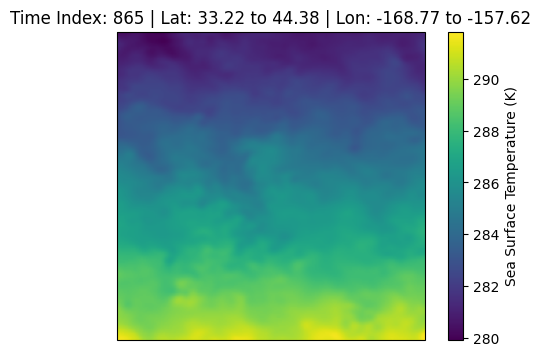

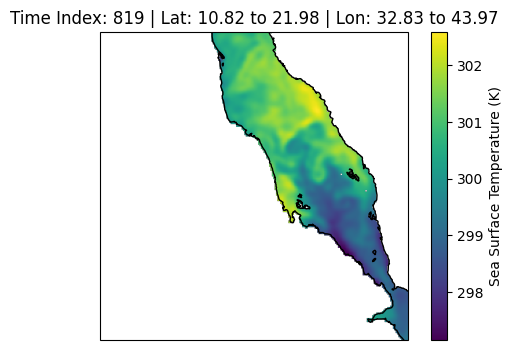

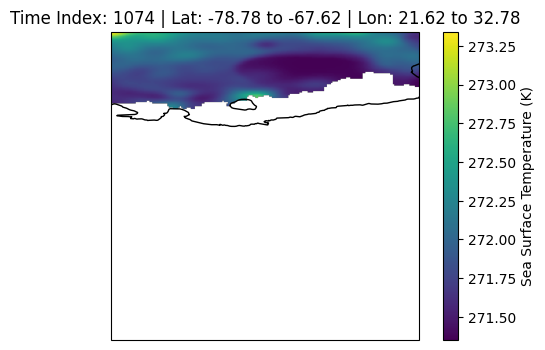

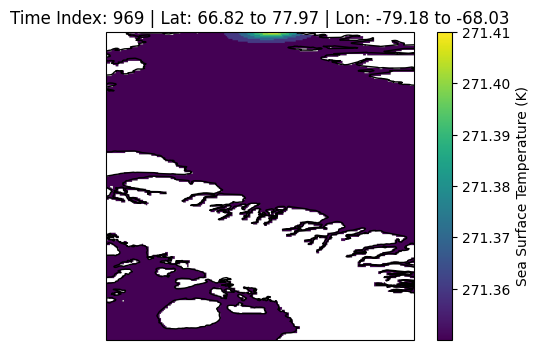

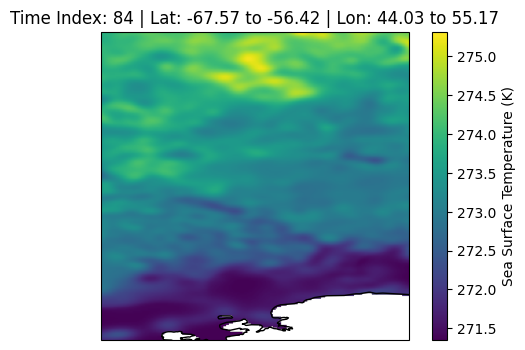

In [186]:
import zarr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import random

def plot_tiles(store):
    # Get the total number of tiles
    total_tiles = store['analysed_sst'].shape[0]

    # Get the metadata for tile positions
    tile_metadata = store['tile_metadata'][:]

    # Get the lat and lon arrays
    latitudes = store['latitudes'][:]
    longitudes = store['longitudes'][:]

    # Randomly select a few tiles
    random_tile_indices = np.random.choice(total_tiles, size=min(9, total_tiles), replace=False)

    # Plot each random tile
    for tile_idx in random_tile_indices:
        # Get the tile data
        sst_tile = store['analysed_sst'][tile_idx]
        
        # Get the metadata for this tile
        lat_tile_idx, lon_tile_idx = tile_metadata[tile_idx]
        
        # Get the lat/lon values for this tile
        lat_values = latitudes[lat_tile_idx]
        lon_values = longitudes[lon_tile_idx]
        
        # Create a 2D mesh grid for plotting
        lon_mesh, lat_mesh = np.meshgrid(lon_values, lat_values)
        
        # Plotting with Cartopy for coastlines
        fig, ax = plt.subplots(figsize=(6, 4), subplot_kw={'projection': ccrs.PlateCarree()})
        ax.set_extent([lon_values.min(), lon_values.max(), lat_values.min(), lat_values.max()], crs=ccrs.PlateCarree())
        
        # Plot the SST data
        im = ax.imshow(sst_tile, cmap='viridis', origin='lower', 
                    extent=[lon_values.min(), lon_values.max(), lat_values.min(), lat_values.max()], 
                    transform=ccrs.PlateCarree())
        plt.colorbar(im, ax=ax, label='Sea Surface Temperature (K)')
        
        # Add coastal lines
        ax.coastlines()
        
        # Use the time index as part of the title instead of the time string
        ax.set_title(f'Time Index: {tile_idx} | Lat: {lat_values.min():.2f} to {lat_values.max():.2f} | '
                    f'Lon: {lon_values.min():.2f} to {lon_values.max():.2f}')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        
        plt.show()

# Open the Zarr store
store = zarr.open("tiles_output.zarr", mode="r")
plot_tiles(store)


## Calculate amount of empty tiles in the dataset

In [162]:
import numpy as np

def check_emptiness(var):
    """
    Analyze a 3D numpy array to determine the percentage of empty tiles
    and the total count of empty data points using vectorized operations.

    Parameters:
    var (numpy.ndarray): A 3D numpy array where each element can be NaN.
                         The dimensions are expected to be (time, latitude, longitude).

    Returns:
    tuple: A tuple containing:
           - percentage_empty_tiles (float): The percentage of tiles that are completely empty (all NaN).
           - empty_data_points_count (int): The total count of empty data points (NaN values) across all tiles.
    """
    # Calculate the total number of tiles
    total_tiles = var.shape[1] * var.shape[2]

    # Check for completely empty tiles
    empty_tiles_mask = np.isnan(var).all(axis=(1, 2))
    empty_tiles_count = np.sum(empty_tiles_mask)

    # Count empty data points in non-empty tiles
    non_empty_tiles_mask = ~empty_tiles_mask
    non_empty_tiles = var[non_empty_tiles_mask]
    empty_data_points_count = np.sum(np.isnan(non_empty_tiles))

    # Calculate the percentage of empty tiles
    percentage_empty_tiles = (empty_tiles_count / total_tiles) * 100

    return percentage_empty_tiles, empty_data_points_count

In [163]:
import zarr
import numpy as np

path = "tiles_output.zarr"

# Open the Zarr store
store = zarr.open(path, mode="r")

# Assuming the data is stored in a dataset within the Zarr store
dataset = store['analysed_sst']

# Load the data into a NumPy array
data_array = np.array(dataset)
# Open the Zarr store
percentage_empty_tiles, empty_data_points_count = check_emptiness(data_array)

# Print the results
print("Percentage of empty tiles:", percentage_empty_tiles)
print("Total empty data points:", empty_data_points_count)


Percentage of empty tiles: 0.4424426020408163
Total empty data points: 15007995


## Remove empty Tiles

In [183]:
import numpy as np
import zarr

# Open the existing Zarr store
store = zarr.open("tiles_output.zarr", mode="r+")

# Access the SST array and metadata
sst_array = store['analysed_sst']
tile_metadata = store['tile_metadata']
latitudes = store['latitudes'][:]
longitudes = store['longitudes'][:]

# Get dataset attributes
n_tiles_lat = store.attrs['n_tiles_lat']
n_tiles_lon = store.attrs['n_tiles_lon']
tile_size = store.attrs['tile_size']

# Identify non-empty tiles
non_empty_tiles = []
new_lat_indices = set()
new_lon_indices = set()

for t_idx in range(sst_array.shape[0]):
    tile = sst_array[t_idx]
    if not np.isnan(tile).all() and not (tile == 0).all():
        non_empty_tiles.append(t_idx)
        lat_idx, lon_idx = tile_metadata[t_idx]
        new_lat_indices.add(lat_idx)
        new_lon_indices.add(lon_idx)

# Sort indices to maintain proper order
new_lat_indices = sorted(new_lat_indices)
new_lon_indices = sorted(new_lon_indices)

# Create a new Zarr store for non-empty tiles
new_store = zarr.open("non_empty_tiles_output.zarr", mode="w")

# Create datasets for SST for non-empty tiles
new_sst_array = new_store.create('analysed_sst',
                                 shape=(len(non_empty_tiles), tile_size, tile_size),
                                 dtype='float32', chunks=(1, tile_size, tile_size))

# Create arrays for updated latitude/longitude
new_latitudes = new_store.create('latitudes',
                                 shape=(len(new_lat_indices), tile_size),
                                 dtype='float32', chunks=(1, tile_size))

new_longitudes = new_store.create('longitudes',
                                  shape=(len(new_lon_indices), tile_size),
                                  dtype='float32', chunks=(1, tile_size))

# Create an array to store metadata for non-empty tiles
new_tile_metadata = new_store.create('tile_metadata',
                                     shape=(len(non_empty_tiles), 2),  # Store lat_idx, lon_idx
                                     dtype='int32')

# Create mappings for new lat/lon indices
lat_idx_map = {old_idx: new_idx for new_idx, old_idx in enumerate(new_lat_indices)}
lon_idx_map = {old_idx: new_idx for new_idx, old_idx in enumerate(new_lon_indices)}

# Copy non-empty tiles and update metadata
for i, t_idx in enumerate(non_empty_tiles):
    new_sst_array[i] = sst_array[t_idx]
    lat_idx, lon_idx = tile_metadata[t_idx]

    # Update lat/lon metadata with new mapped indices
    new_tile_metadata[i] = [lat_idx_map[lat_idx], lon_idx_map[lon_idx]]

# Store updated latitude and longitude references
for new_idx, old_idx in enumerate(new_lat_indices):
    new_latitudes[new_idx] = latitudes[old_idx]

for new_idx, old_idx in enumerate(new_lon_indices):
    new_longitudes[new_idx] = longitudes[old_idx]

# Update dataset attributes
new_store.attrs['n_tiles_lat'] = len(new_lat_indices)
new_store.attrs['n_tiles_lon'] = len(new_lon_indices)
new_store.attrs['tile_size'] = tile_size

print("Non-empty tiles and their metadata saved successfully.")


Non-empty tiles and their metadata saved successfully.


In [169]:
import zarr

# Open the existing Zarr store
store = zarr.open("non_empty_tiles_output.zarr", mode="r")
# Access a specific dataset
dataset_key = 'analysed_sst'
dataset = store[dataset_key]

# Print dataset information
print(f"\nInformation about the dataset '{dataset_key}':")
print(f"Shape: {dataset.shape}")
print(f"Data type: {dataset.dtype}")
print(f"Chunks: {dataset.chunks}")


Information about the dataset 'analysed_sst':
Shape: (1314, 224, 224)
Data type: float32
Chunks: (1, 224, 224)


In [185]:
import zarr
import numpy as np

# Open the Zarr store
path = "non_empty_tiles_output.zarr"

# Open the Zarr store
store = zarr.open(path, mode="r")

# Assuming the data is stored in a dataset within the Zarr store
dataset = store['analysed_sst']

# Load the data into a NumPy array
data_array = np.array(dataset)
# Open the Zarr store
percentage_empty_tiles, empty_data_points_count = check_emptiness(data_array)

# Print the results
print("Percentage of empty tiles:", percentage_empty_tiles)
print("Total empty data points:", empty_data_points_count)


Percentage of empty tiles: 0.0
Total empty data points: 15007995


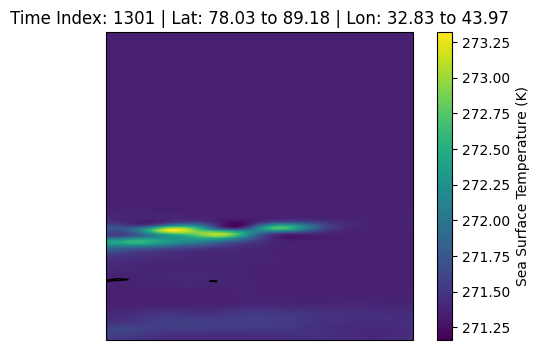

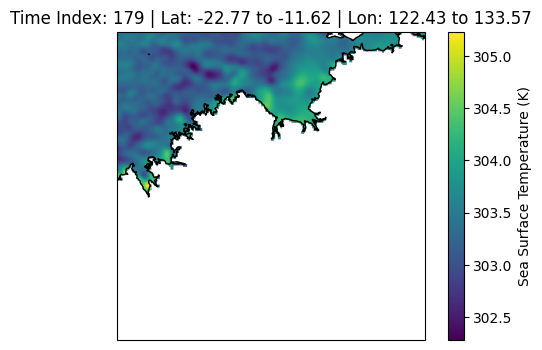

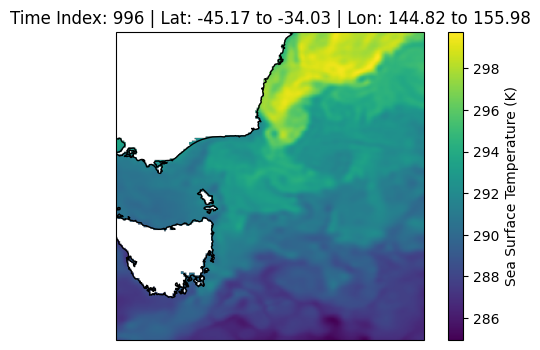

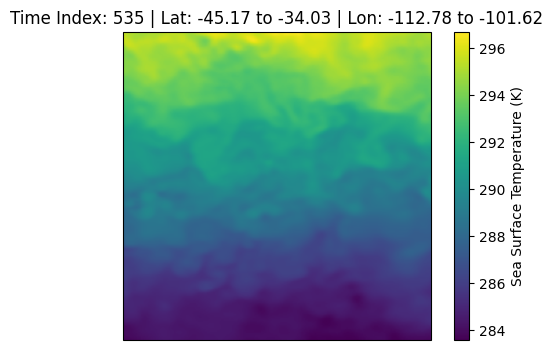

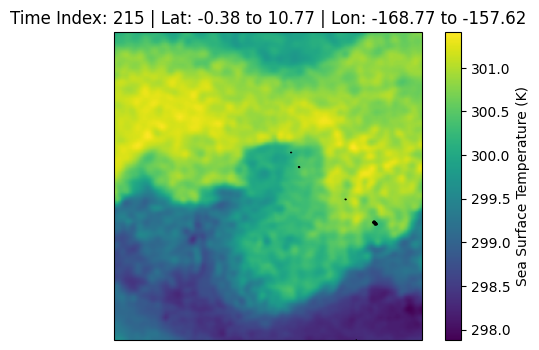

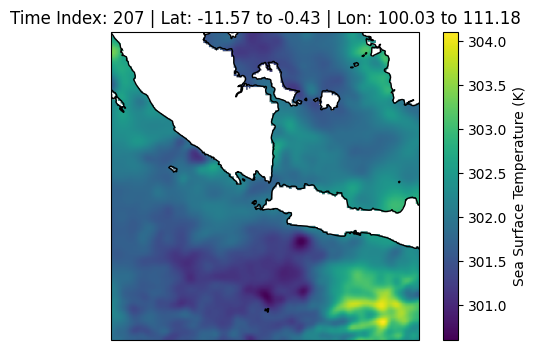

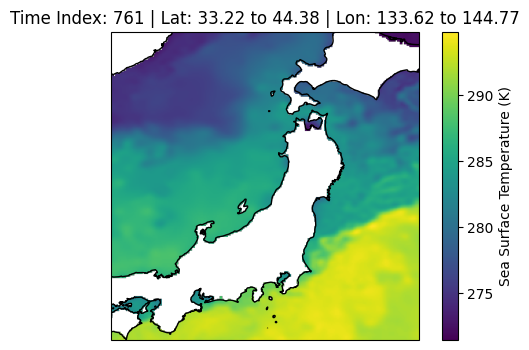

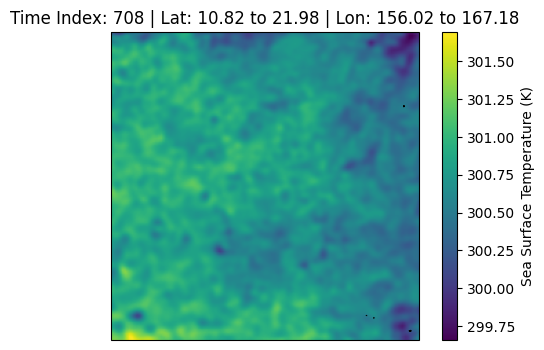

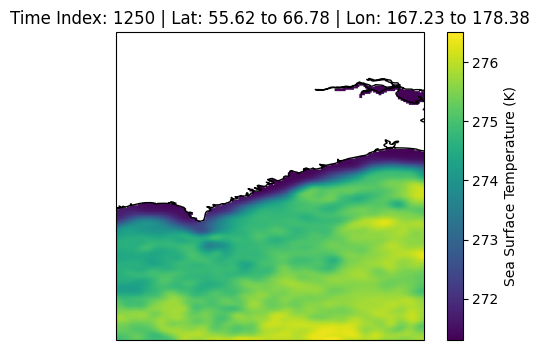

In [187]:
import zarr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import random

# Open the Zarr store
store = zarr.open("non_empty_tiles_output.zarr", mode="r")

plot_tiles(store)
